In [364]:
import os
import math
import numpy as np
import scipy as sp
import pandas as pd
import ujson as json
import matplotlib.pyplot as plt
%matplotlib notebook

from tqdm import tqdm
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score

### Read data

In [2]:
shas, groups = zip(*[x.split(',') for x in open('samples_by_packer_group.txt').read().splitlines()])
sha_group = {a: int(b) for a, b in zip(shas, groups)}
sha_label = {a: 1 if int(b) else 0 for a, b in zip(shas, groups)}

In [3]:
shas = list(sha_label.keys())

In [4]:
# Extracting named features from TC report
section_names = []
data_size = []
entropies = [] 
section_sizes = []
dates = [] 
import_names = [] 
max_sec_ent = [] # highest section entropy in section_list
api_list = [] # list of api_lists in import_list
warnings = [] # names of warnings in warning_list
resources = [] # names in resource_list
opH_size = [] # size of Optional Header
mean_sec_ent = [] # mean of entropies of sections in section_list
min_sec_ent = [] # lowest section entropy in section_list

# appending all needed features form TC report
for sha in tqdm(shas):
    report = json.load(
        open("reports/{}/{}.json".format(sha[-2:], sha), 'rb')
    )
    entry = report['coreReport']['entries']['entry_list'][0]
    
    # It is possible sections do not exist!
    if 'sections' not in entry['metadata']['application']['pe']:
        section_sizes.append(0)
        section_names.append([])
    else:
        section_names.append(
            [sec.get('name', 'NO_NAME')
             for sec in entry['metadata']['application']['pe']['sections']['section_list']])

        section_sizes.append(sum([int(sec.get('size'),0)
             for sec in entry['metadata']['application']['pe']['sections']['section_list']]))
    
    # It is possible imports do not exist!
    if 'imports' not in entry['metadata']['application']['pe']:
        import_names.append([])
        api_list.append([])
    else:
        import_names.append(
            [imp.get('name', 'NO_NAME')
             for imp in entry['metadata']['application']['pe']['imports']['import_list']])
        api_list.append([imp.get('api_list', '[]')
             for imp in entry['metadata']['application']['pe']['imports']['import_list']])
    
    # It is possible warnings do not exist!
    if 'warnings' not in entry['info']['validation']:
        warnings.append([])
    else:
        warnings.append(entry['info']['validation']['warnings']['warning_list'])
    
    if 'resources' not in entry['metadata']['application']['pe']:
        resources.append([])
    else:
        resources.append(
            [imp.get('type', 'NO_TYPE')
             for imp in entry['metadata']['application']['pe']['resources']['resource_list']])
        
    data_size.append(entry['info']['file']['size'])
    entropies.append(entry['info']['file']['entropy'])
    dates.append(entry['metadata']['application']['pe']['fileHeader']['timeDateStamp'])
    
    max_sec_ent.append(
        max([float(sec.get('entropy'))
             for sec in entry['metadata']['application']['pe']['sections']['section_list']]))
    
    opH_size.append(entry['metadata']['application']['pe']['optionalHeader']['sizeOfHeaders'])
    
    mean_sec_ent.append(
          np.mean([float(sec.get('entropy'))
             for sec in entry['metadata']['application']['pe']['sections']['section_list']]))
    
    min_sec_ent.append(
          min([float(sec.get('entropy'))
             for sec in entry['metadata']['application']['pe']['sections']['section_list']]))

100%|██████████| 43784/43784 [02:18<00:00, 315.66it/s]


In [5]:
# Extracting apis from api_list
konacna=[]
for lista in api_list:
    pomocna=[]
    for lis in lista:
        for li in lis:
            if(li not in pomocna):
                pomocna.append(li)
    konacna.append(pomocna)

# Removing repeating names in resources
resource_list= []
for lista in resources:
    lis=[]
    for li in lista:
        if li not in lis:
            lis.append(li)
    resource_list.append(lis)        

In [6]:
import calendar
d={v: k for k,v in enumerate(calendar.month_abbr)}

In [7]:
# Converting from hexadecimal to decimal
data_size_ints = [int(x,0) for x in data_size]
opH_size_ints = [int(x, 0) for x in opH_size]

entropies_f = [round(float(x),2) for x in entropies]
max_sec_ent_f = [round(float(x),2) for x in max_sec_ent]
mean_sec_ent_f = [round(float(x),2) for x in mean_sec_ent]
min_sec_ent_f = [round(float(x),2) for x in min_sec_ent]


In [8]:
# Converting the size of Optional Header from bytes to kilobytes
opH_size_ints=[i/1024 for i in opH_size_ints]

In [9]:
from functools import reduce

# If size of file is smaller than sum of all sections of a file, than that is suspicious
# So we have put that as a feature
diff=[]
for i, size in enumerate(data_size_ints):
    if(size-section_sizes[i] < 0):
        diff.append(1)
    else:
        diff.append(0)

# Comparison of size of Optional Header to the mean of sizes of all Optional Headers
opH=[]
mean = reduce(lambda a, b: a + b, opH_size_ints) / len(opH_size_ints)
for i, size in enumerate(opH_size_ints):
    if(size < mean):
        opH.append(0)
    else:
        opH.append(1)


In [10]:
# Converting the size of Optional Header from kilobytes to megabytes
opH_size_ints_2=[i/1024 for i in opH_size_ints]

In [11]:
# If the date says that a file was made before 1985, or later than now, that is suspicious
# We made that a feature here

import datetime
import time

dates_without_day=[date[4:] for date in dates]
dates_num = [str(d[p[:3]])+p[3:] for p in dates_without_day]

dates_final = [datetime.datetime.strptime(dat, "%m %d %H:%M:%S %Y").strftime("%Y-%m-%d %H:%M:%S") for dat in dates_num]

tmpTime = time.strftime("%Y-%m-%d %I:%M:%S")
timee = "1985-1-1 00:00:00"
dates_bin = [1 if (tim > tmpTime or timee>tim) else 0 for tim in dates_final]


In [12]:
sections = pd.DataFrame(data={'sha1': shas, 'section_names': section_names,
                              'import_names':import_names,'size':diff, 'entropy':entropies_f,
                              'date':dates_bin, 'max_section_entropy':max_sec_ent_f,
                              'mean_section_entropy':mean_sec_ent_f,'min_sec_ent':min_sec_ent,
                             'import_apis':konacna,'warnings':warnings,
                             'resource_list':resource_list, 'opH':opH_size_ints_2})
sections = sections[['sha1', 'section_names','import_names','import_apis','warnings',
                     'resource_list','size','entropy','max_section_entropy',
                     'min_sec_ent','mean_section_entropy','date','opH']]

In [13]:
sections['group'] = [sha_group[sha1] for sha1 in tqdm(sections.sha1.values)]
sections['label'] = [sha_label[sha1] for sha1 in tqdm(sections.sha1.values)]
sections

100%|██████████| 43784/43784 [00:00<00:00, 1706961.07it/s]


,sha1,section_names,import_names,import_apis,warnings,resource_list,size,entropy,max_section_entropy,min_sec_ent,mean_section_entropy,date,opH,group,label
0,000003cf1b52a990d99352da24aa73585b97647c,"[.text, .rdata, .data, .rsrc]","[ADVAPI32.dll, COMCTL32.dll, GDI32.dll, KERNEL...","[LookupPrivilegeValueA, OpenProcessToken, Copy...",[Whitelisted certificate: Microsoft Corporatio...,[RT_VERSION],0,6.20,6.51,1.044567,4.24,0,0.003906,1,1
1,000007e5aa61eff1435edf63459d70a99441109d,"[.text, .rsrc, .reloc]",[mscoree.dll],[_CorExeMain],[],"[RT_ICON, RT_GROUP_ICON, RT_VERSION]",0,4.51,5.40,0.013127,2.75,0,0.007812,0,0
2,000023255f375fb8397182833c8dd660fd760202,"[.text, .rdata, .data, .idata, .rsrc, .reloc]","[KERNEL32.dll, MSVCR100.dll, QtCore4.dll, QtGu...","[GetSystemTimeAsFileTime, GetCurrentProcessId,...",[PEHeader.SizeOfStackReserve is fixable],[RT_MANIFEST],0,5.59,6.29,3.787657,4.92,0,0.003906,0,0
3,000023cf6df3479eef56dbdd5152382a9c22a4e8,"[.text, .rdata, .data, .pdata, .gfids, .reloc]","[KERNEL32.dll, VCRUNTIME140.dll, api-ms-win-cr...","[GetModuleHandleW, IsProcessorFeaturePresent, ...",[],[],0,5.45,5.86,0.159084,2.47,0,0.003906,0,0
4,0000379bd1ea62b8147bba528f1a186424ca43b3,"[UPX0, UPX1, .rsrc]","[ADVAPI32.dll, COMCTL32.dll, GDI32.dll, KERNEL...","[RegEnumKeyA, InitCommonControlsEx, Escape, Lo...","[Whitelisted certificate: Digital River, Inc. ...","[RT_CURSOR, RT_BITMAP, RT_ICON, RT_DIALOG, RT_...",0,7.86,7.93,0.000000,4.37,0,0.003906,3,1
5,000045c34059978f905862f0878b7e583c4f4561,"[UPX0, UPX1, UPX2]","[KERNEL32.DLL, libcairo-2.dll, libcroco-0.6-3....","[LoadLibraryA, GetProcAddress, VirtualProtect,...",[PEHeader.AddressOfEntryPoint is fixable],[],0,7.59,7.92,0.000000,4.38,0,0.003906,3,1
6,00004a9067a95c6a85618aaa061f7af85abef948,"[UPX0, UPX1, .rsrc]","[KERNEL32.DLL, advapi32.dll, comctl32.dll, gdi...","[LoadLibraryA, GetProcAddress, VirtualProtect,...","[ImageHeader.Characteristics is fixable, PEHea...","[RT_CURSOR, RT_BITMAP, RT_ICON, RT_DIALOG, RT_...",0,7.95,8.00,0.000000,4.11,0,0.003906,3,1
7,000057e8d0be48f95181365c28dc9b0d25dd1771,"[.text, .rdata, .data, .rsrc, .reloc]","[ACE.dll, ADVAPI32.dll, AutomationServer.dll, ...","[?get_handle@ACE_Event_Handler@@UBEPAXXZ, ?set...",[],[RT_MANIFEST],0,5.54,5.74,3.935130,4.92,0,0.003906,0,0
8,0000618bda52300218d223f02e3323406d9e1640,"[.text, .data, .rsrc]","[ADVAPI32.dll, KERNEL32.dll, OLEAUT32.dll, SHL...","[RegSetValueExW, RegDeleteKeyW, RegCreateKeyEx...",[],"[RT_ICON, RT_MENU, RT_STRING, RT_GROUP_ICON, R...",0,5.19,5.32,2.712999,4.30,0,0.003906,0,0
9,00006234076ecb1fea4ee2df95f9470b00ca043c,"[.text, .rdata, .data, .pdata, .tls, .rsrc, .r...","[KERNEL32.dll, VCRUNTIME140.dll, api-ms-win-cr...","[TerminateProcess, RtlLookupFunctionEntry, Rtl...",[],"[RT_VERSION, RT_MANIFEST]",0,5.62,6.15,0.000000,3.76,0,0.003906,0,0


In [14]:
labels = sections['label'].values
groups = sections['group'].values
shas = sections['sha1'].values

In [15]:
X_train, X_val, y_train, y_val = train_test_split(
    shas, labels, test_size=0.2, random_state=42, stratify=groups
)

In [16]:
m_train = np.where(sections['sha1'].isin(X_train).values)[0]
m_val = np.where(sections['sha1'].isin(X_val).values)[0]

In [167]:
# Dataset size and number of packer samples
len(X_train), y_train.sum()

(35027, 17458)

In [18]:
# Packer percentage in the dataset
(y_train.sum() / X_train.shape[0] * 100)

49.84155080366575

In [19]:
# Check the dataset structure!
Counter(groups).most_common()

[(0, 21962), (3, 14604), (4, 3336), (1, 1956), (2, 1926)]

### Create features from section names

#### Approach 1 - most used names

In [20]:
# Count all features for each given feature type from train dataset!
# section names
cnt = Counter()
for names in tqdm(sections.iloc[m_train].section_names.values):
    cnt += Counter(names)
    
# import names    
cnt_imp = Counter()
for names in tqdm(sections.iloc[m_train].import_names.values):
    cnt_imp += Counter(names)

# import apis    
cnt_imp_api = Counter()
for names in tqdm(sections.iloc[m_train].import_apis.values):
    cnt_imp_api += Counter(names)
    
# warnings    
cnt_warnings = Counter()
for names in tqdm(sections.iloc[m_train].warnings.values):
    cnt_warnings += Counter(names)
    
# resource list    
cnt_resources = Counter()
for names in tqdm(sections.iloc[m_train].resource_list.values):
    cnt_resources += Counter(names)

100%|██████████| 35027/35027 [00:00<00:00, 51200.21it/s]


In [21]:
# Pick top x for given feature types
print("Most common section names")
num_used = 10
for a, b in cnt.most_common()[:num_used]:
    print("{:10}\t{:5}".format(a, b))

print("Most common import names")
num_used_imp = 10
for a, b in cnt_imp.most_common()[:num_used_imp]:
    print("{:10}\t{:5}".format(a, b))

print("Most common apis in import_list")
num_used_imp_api = 25
for a, b in cnt_imp_api.most_common()[:num_used_imp_api]:
    print("{:10}\t\t{:5}".format(a, b))
    
print("Most common warnings")    
num_used_war = 25
for a, b in cnt_warnings.most_common()[:num_used_war]:
    print("{:10}\t\t{:5}".format(a, b))

print("Most common resource names in resource list")
num_used_res = 16
for a, b in cnt_resources.most_common()[:num_used_res]:
    print("{:10}\t\t{:5}".format(a, b))

Most common section names
.rsrc     	30385
.text     	14879
.data     	12428
.reloc    	12245
.rdata    	11621
NO_NAME   	10726
UPX0      	 6881
UPX1      	 6881
.idata    	 3249
.pdata    	 3180
pec1      	 2373
.imports  	 2260
pec2      	 1743
UPX2      	 1618
.adata    	 1303
.tls      	 1277
Most common import names
KERNEL32.DLL	10211
KERNEL32.dll	 9070
USER32.dll	 7990
user32.dll	 7241
ole32.dll 	 6310
ADVAPI32.dll	 5893
kernel32.dll	 5419
oleaut32.dll	 4491
advapi32.dll	 4404
SHELL32.dll	 4332
GDI32.dll 	 3976
comdlg32.dll	 3711
OLEAUT32.dll	 3625
COMCTL32.dll	 2787
gdi32.dll 	 2754
msvcrt.dll	 2690
Most common apis in import_list
GetProcAddress		20331
LoadLibraryA		16854
ExitProcess		12033
GetModuleHandleA		 9451
VirtualAlloc		 8555
VirtualFree		 8333
RegCloseKey		 8216
UnhandledExceptionFilter		 8175
GetCurrentThreadId		 8119
MessageBoxA		 7844
GetCurrentProcess		 7525
TerminateProcess		 7260
CloseHandle		 7218
GetCurrentProcessId		 7190
Sleep     		 6970
GetLastError		 6741
W

In [22]:
# Enumerating features and their frequencies for each given feature type
# warnings
most_used_war = [x[0] for x in cnt_warnings.most_common()[:num_used_war]]
name_ind_war = {name: i for i, name in enumerate(most_used_war)}

# import 
most_used_imp = [x[0] for x in cnt_imp.most_common()[:num_used_imp]]
name_ind_imp = {name: i for i, name in enumerate(most_used_imp)}

# import apis
most_used_imp_api = [x[0] for x in cnt_imp_api.most_common()[:num_used_imp_api]]
name_ind_imp_api = {name: i for i, name in enumerate(most_used_imp_api)}

# resource list
most_used_res = [x[0] for x in cnt_resources.most_common()[:num_used_res]]
name_res = {name: i for i, name in enumerate(most_used_res)}

# section names (all)
most_used_all = [x[0] for x in cnt.most_common()[:len(cnt)]]
name_ind_all = {name: i for i, name in enumerate(most_used_all)}

inv_name_ind_all = {v: k for k, v in name_ind_all.items()}

# section names
most_used = [x[0] for x in cnt.most_common()[:num_used]]
name_ind = {name: i for i, name in enumerate(most_used)}

In [23]:
# section names analysis, of their correlation with packed files
data_analysis = np.zeros((sections.shape[0], len(cnt)))
data_analysis.shape

pos = np.zeros(len(cnt))
neg = np.zeros(len(cnt))

for i, names in enumerate(tqdm(sections.iloc[m_train].section_names.values)):
    for name in names:
        if name in name_ind_all:
            data_analysis[i, name_ind_all[name]] += 1
            
            if(sections['label'].values[i] == 1):
                pos[name_ind_all[name]] += 1
            else:
                neg[name_ind_all[name]] += 1
                
suspicious_sections = []
suspicious_sections_80 = []
perc = pos / (pos+neg) *100
print(perc)
for i,sec in enumerate(perc):
    if(sec > 95 ):
        suspicious_sections.append(inv_name_ind_all[i])
    if(sec > 80 ):
        suspicious_sections_80.append(inv_name_ind_all[i])

# suspicious section names, that appear over 95% of times in section list packed files
vec=[]
for sec_li in sections.iloc[m_train].section_names.values:
    flag =0
    for name in sec_li:
        if name in suspicious_sections:
            flag = 1
            vec.append(1)
            break
    if(flag == 0):
        vec.append(0)

# suspicious section names, that appear over 80% of times in section list packed files        
vec_80 =[]
for sec_li in sections.iloc[m_train].section_names.values:
    flag =0
    for name in sec_li:
        if name in suspicious_sections_80:
            flag = 1
            vec_80.append(1)
            break
    if(flag == 0):
        vec_80.append(0)
        

100%|██████████| 35027/35027 [00:00<00:00, 51412.98it/s]


[59.30557841 58.33725385 59.30157708 ...  0.          0.
  0.        ]


In [408]:
# Count all the mentioned features
data = np.zeros((sections.shape[0], num_used+num_used_war+ num_used_res+num_used_imp+ num_used_imp_api + 13))

# 10 most common section names and number of other section names in section list
for i, names in enumerate(tqdm(sections.section_names.values)):
    for name in names:
        if name in name_ind:
            data[i, name_ind[name]] += 1
        else:
            data[i, num_used] += 1
            
# 10 most common import names and number of other import names in import list            
for i, names in enumerate(tqdm(sections.import_names.values)):
    for imp in names:
        if imp in name_ind_imp:
            data[i,num_used+1+ name_ind_imp[imp]] += 1
        else:
            data[i,num_used+1+ num_used_imp] += 1

# 25 most common import apis and number of other import apis in import list
for i, names in enumerate(tqdm(sections.import_apis.values)):
    for imp in names:
        if imp in name_ind_imp_api:
            data[i,num_used+num_used_imp+1+ name_ind_imp_api[imp]] += 1
            
# 25 most common warnings and number of other warnings in warnings list            
for i, names in enumerate(tqdm(sections.warnings.values)):
    for imp in names:
        if imp in name_ind_war:
            data[i,num_used+num_used_imp+num_used_imp_api+1+ name_ind_war[imp]] += 1
            
# 16 most common resources and number of other resources in resource list 
for i, names in enumerate(tqdm(sections.resource_list.values)):
    for imp in names:
        if imp in name_res:
            data[i,num_used+num_used_imp+num_used_imp_api+ num_used_war+1+ name_res[imp]] += 1
            
for i, size in enumerate(tqdm(sections['size'].values)):
    data[i][num_used+ num_used_imp+num_used_war+ num_used_imp_api+num_used_res + 2] = size
for i, ent in enumerate(tqdm(sections['entropy'].values)):
    data[i][num_used+ num_used_imp+num_used_war+ num_used_imp_api+num_used_res + 3] = ent
for i, dat in enumerate(tqdm(sections['date'].values)):
    data[i][num_used+ num_used_imp+num_used_war+ num_used_imp_api+num_used_res + 4] = dat
for i, v in enumerate(tqdm(vec)):
    data[i][num_used+ num_used_imp+num_used_war+ num_used_imp_api+num_used_res + 5] = v
for i, v in enumerate(tqdm(vec_80)):
    data[i][num_used+ num_used_imp+num_used_war+ num_used_imp_api+num_used_res + 6] = v
for i, ent_m in enumerate(tqdm(sections['max_section_entropy'].values)):
    data[i][num_used+ num_used_imp+num_used_war+ num_used_imp_api+num_used_res + 7] = ent_m
for i, ent_m in enumerate(tqdm(sections['mean_section_entropy'].values)):
    data[i][num_used+ num_used_imp+num_used_war+ num_used_imp_api+num_used_res + 8] = ent_m
for i, ent_m in enumerate(tqdm(sections['min_sec_ent'].values)):
    data[i][num_used+ num_used_imp+num_used_war+ num_used_imp_api+num_used_res + 9] = ent_m
for i, imp in enumerate(tqdm(sections['import_names'].values)):
    data[i][num_used+ num_used_imp+num_used_war+ num_used_imp_api+num_used_res + 10] = len(imp)
for i, imp in enumerate(tqdm(sections['import_apis'].values)):
    data[i][num_used+ num_used_imp+num_used_war+ num_used_imp_api+num_used_res + 11] = len(imp)
for i, size in enumerate(tqdm(sections['opH'].values)):
    data[i][num_used+ num_used_imp+num_used_war+ num_used_imp_api+num_used_res + 12] = size

100%|██████████| 43784/43784 [00:00<00:00, 1042788.55it/s]


## Funkcija za plotanje treniranja

In [184]:
from sklearn import cross_validation
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.learning_curve import learning_curve

In [185]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

## XGBoost

In [263]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV

In [264]:
# model
model_XGB = XGBClassifier()

In [265]:
# model's hyperparameters
model_XGB.get_params().keys()

dict_keys(['base_score', 'booster', 'colsample_bylevel', 'colsample_bytree', 'gamma', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'n_estimators', 'n_jobs', 'nthread', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'seed', 'silent', 'subsample'])

In [266]:
# define the parameter values that should be searched
n_estimators_range = list(range(1, 201))
learning_range = list(range(1, 31))
learning_range = [x / 10 for x in learning_range]
depth_range = list(range(1, 101))
child_weight_range = list(range(1, 31))
child_weight_range = [x / 10 for x in child_weight_range]
max_delta_step_range = list(range(1, 10))
scale_pos_weight_range = list(range(1, 10))
scale_pos_weight_range.append(0.5)
scale_pos_weight_range.append(0.6)
scale_pos_weight_range.append(0.7)
scale_pos_weight_range.append(0.8)
scale_pos_weight_range.append(0.9)
base_score_range = list(range(5, 10))
base_score_range = [x / 10 for x in base_score_range]
subsample_range = list(range(1, 10))
subsample_range = [x / 10 for x in subsample_range]
colsample_bytree_range = list(range(1, 10))
colsample_bytree_range = [x / 10 for x in colsample_bytree_range]
colsample_bylevel_range = list(range(1, 10))
colsample_bylevel_range = [x / 10 for x in colsample_bylevel_range]

In [268]:
# specify "parameter distributions" rather than a "parameter grid"
# for unmentioned parameters we use default values in our model
param_dist_XGB = dict(learning_rate = learning_range,
                      max_depth=depth_range,
                      base_score=base_score_range)

In [269]:
# we use the RandomizedSearchCV to find the best parameters for our XGB model
rand_XGB = RandomizedSearchCV(model_XGB, param_dist_XGB, cv=10, scoring='accuracy', n_iter=20, random_state=5, return_train_score=False)
rand_XGB.fit(data, labels)
pd.DataFrame(rand_XGB.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. U

/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. U

/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. U

/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. U

/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. U

/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. U

/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. U

,mean_test_score,std_test_score,params
0,0.741024,0.148985,"{'max_depth': 16, 'learning_rate': 3.0, 'base_..."
1,0.727275,0.141915,"{'max_depth': 55, 'learning_rate': 2.3, 'base_..."
2,0.992235,0.003109,"{'max_depth': 80, 'learning_rate': 1.1, 'base_..."
3,0.991527,0.003300,"{'max_depth': 18, 'learning_rate': 1.0, 'base_..."
4,0.992166,0.003194,"{'max_depth': 47, 'learning_rate': 0.1, 'base_..."
5,0.990841,0.003750,"{'max_depth': 87, 'learning_rate': 1.3, 'base_..."
6,0.847090,0.104467,"{'max_depth': 21, 'learning_rate': 2.6, 'base_..."
7,0.974877,0.027992,"{'max_depth': 14, 'learning_rate': 1.4, 'base_..."
8,0.991869,0.003321,"{'max_depth': 33, 'learning_rate': 1.1, 'base_..."
9,0.992120,0.003273,"{'max_depth': 41, 'learning_rate': 0.8, 'base_..."


<IPython.core.display.Javascript object>


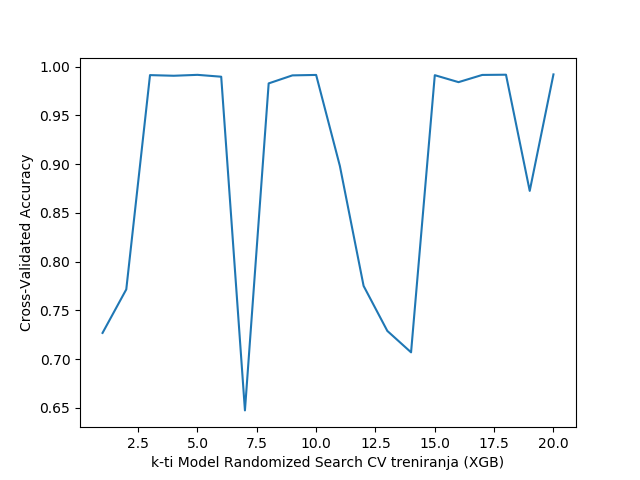

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


In [365]:
# plot of randomized search results
rand_XGB_mean_scores = rand_XGB.cv_results_['mean_test_score']
plt.plot(list(range(1, 21)), rand_XGB_mean_scores)
plt.xlabel('k-ti Model Randomized Search CV treniranja (XGB)')
plt.ylabel('Cross-Validated Accuracy')

In [271]:
# examine the best model
print(rand_XGB.best_score_)
print(rand_XGB.best_params_)

0.992714233509958
{'max_depth': 64, 'learning_rate': 0.3, 'base_score': 0.9}


In [274]:
m_XGB = XGBClassifier(max_depth = rand_XGB.best_params_['max_depth'],
                      learning_rate = rand_XGB.best_params_['learning_rate'],
                      base_score = rand_XGB.best_params_['base_score'])
m_XGB.fit(data[m_train], labels[m_train])
# make predictions for test data
y_pred = m_XGB.predict(data[m_val])
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(predictions, labels[m_val])
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 99.19%


/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


<IPython.core.display.Javascript object>


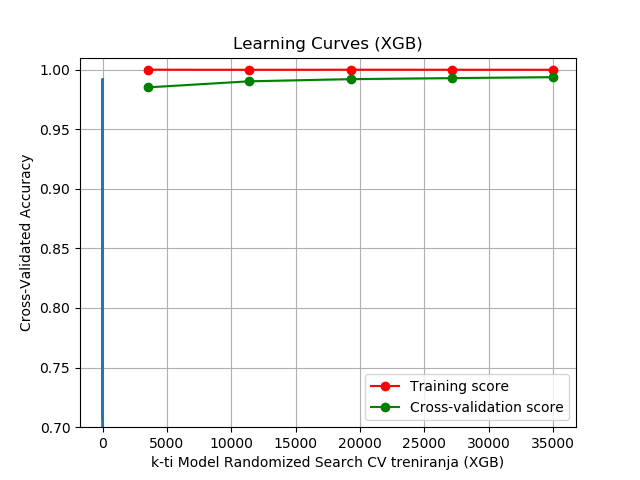

/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. U

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


In [342]:
# plot of the training and validation process for the model m_XGB
title = "Learning Curves (XGB)"
cv_XGB = cross_validation.ShuffleSplit(data.shape[0], n_iter=2, test_size=0.2, random_state=0)
plt_XGB = plot_learning_curve(m_XGB, title, data, labels, ylim=(0.7, 1.01), cv=cv_XGB, n_jobs=2)
plt_XGB.show()

In [374]:
model_XGB = m_XGB.fit(data[m_train], labels[m_train])

## RandomForest

In [276]:
from sklearn.ensemble import RandomForestClassifier

In [134]:
# model
model_forest = RandomForestClassifier()

In [135]:
# model's (hyper)parameters
model_forest.get_params().keys()

dict_keys(['bootstrap', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [139]:
# define the parameter values that should be searched
depth_range = list(range(1, 101))
oob_score_options = ['True', 'False']
criterion_options = ['gini', 'entropy']
max_features_range = list(range(1, 1001))
max_features_range = [x / 1000 for x in max_features_range]

In [198]:
# specify "parameter distributions" rather than a "parameter grid"
# for unmentioned parameters we use default values in our model
param_dist_forest = dict(max_depth=depth_range, 
                         oob_score=oob_score_options, 
                         criterion=criterion_options, 
                         max_features = max_features_range)

In [141]:
# we use the RandomizedSearchCV to find the best parameters for our XGB model
rand_forest = RandomizedSearchCV(model_forest, param_dist_forest, cv=10, scoring='accuracy', n_iter=20, random_state=5, return_train_score=False)
rand_forest.fit(data, labels)
pd.DataFrame(rand_forest.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

/usr/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliabl

,mean_test_score,std_test_score,params
0,0.963845,6.716864e-03,"{'oob_score': 'True', 'n_estimators': 36, 'min..."
1,0.904189,1.418411e-02,"{'oob_score': 'False', 'n_estimators': 117, 'm..."
2,0.499041,1.279006e-03,"{'oob_score': 'True', 'n_estimators': 3, 'min_..."
3,0.501599,2.920772e-07,"{'oob_score': 'True', 'n_estimators': 145, 'mi..."
4,0.956057,1.148147e-02,"{'oob_score': 'False', 'n_estimators': 30, 'mi..."
5,0.499680,1.566456e-03,"{'oob_score': 'False', 'n_estimators': 159, 'm..."
6,0.967111,6.248746e-03,"{'oob_score': 'True', 'n_estimators': 188, 'mi..."
7,0.960145,9.808068e-03,"{'oob_score': 'False', 'n_estimators': 93, 'mi..."
8,0.943815,2.462023e-02,"{'oob_score': 'False', 'n_estimators': 17, 'mi..."
9,0.907295,1.783622e-02,"{'oob_score': 'False', 'n_estimators': 124, 'm..."


<IPython.core.display.Javascript object>


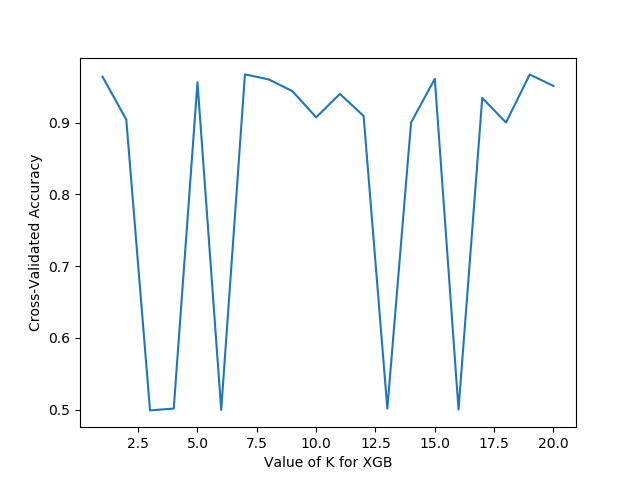

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


In [349]:
# plot of Randomized Search results
rand_forest_mean_scores = rand_forest.cv_results_['mean_test_score']
plt.plot(list(range(1, 21)), rand_forest_mean_scores)
plt.xlabel('Value of K for XGB')
plt.ylabel('Cross-Validated Accuracy')

In [143]:
# examine the best model
print(rand_forest.best_score_)
print(rand_forest.best_params_)

0.9671112735245752
{'oob_score': 'True', 'n_estimators': 188, 'min_samples_split': 0.1, 'max_features': 0.567, 'max_depth': 44, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'bootstrap': 'True'}


In [144]:
m_forest = RandomForestClassifier(max_depth = rand_forest.best_params_['max_depth'],
                                  oob_score = rand_forest.best_params_['oob_score'],
                                  criterion = rand_forest.best_params_['criterion'],
                                  max_features = rand_forest.best_params_['max_features'])

<IPython.core.display.Javascript object>


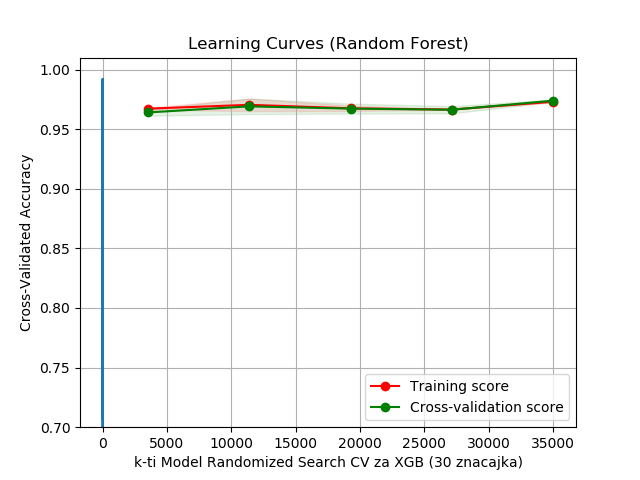

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


In [358]:
# plot of the training and validation process for the model m_XGB
title = "Learning Curves (Random Forest)"
cv_forest = cross_validation.ShuffleSplit(data.shape[0], n_iter=2,
                                    test_size=0.2, random_state=0)
plt_forest = plot_learning_curve(m_forest, title, data, labels, ylim=(0.7, 1.01), cv=cv_XGB, n_jobs=2)
plt_forest.show()

In [373]:
model_f = m_forest.fit(data[m_train], labels[m_train])

## Analiza značajki

In [165]:
from sklearn import *
import sklearn

In [277]:
dictionary = {}
lista=[]
i=0
for p in cnt.most_common()[:num_used]:
    #dictionary[i]print(p[0])
    lista.append(p [0])
lista.append("other_sections")
for p in cnt_imp.most_common()[:num_used_imp]:
    lista.append(p [0])
lista.append("other_imports")
for p in cnt_imp_api.most_common()[:num_used_imp_api]:
    lista.append(p [0])
for p in cnt_warnings.most_common()[:num_used_war]:
    lista.append(p [0])
for p in cnt_resources.most_common()[:num_used_res]:
    lista.append(p [0])
lista.append("size")
lista.append("entropy")
lista.append("date")
lista.append("suspicious_sections_95")
lista.append("suspicious_sections_80")
lista.append("max_entropy")
lista.append("mean_entropy")
lista.append("min_entropy")
lista.append("import_names")
lista.append("import_apis")
lista.append("opH")
len(lista)

111

In [280]:
#print(m_forest.feature_importances_)
import ast
for x,y in zip(lista,model_XGB.feature_importances_):
    print(str(x)+"\t\t"+str(round(float(y)*100,5))+"%")

.rsrc		0.75429%
.text		0.56171%
.data		1.23576%
.reloc		1.36415%
.rdata		1.63698%
NO_NAME		0.09629%
UPX0		0.01605%
UPX1		0.0%
.idata		0.7222%
.pdata		0.46541%
pec1		0.32098%
.imports		0.6259%
pec2		0.0%
UPX2		0.0321%
.adata		0.04815%
.tls		0.22468%
other_sections		3.12951%
KERNEL32.DLL		0.41727%
KERNEL32.dll		0.48146%
USER32.dll		0.44937%
user32.dll		0.16049%
ole32.dll		0.60985%
ADVAPI32.dll		0.28888%
kernel32.dll		0.25678%
oleaut32.dll		0.16049%
advapi32.dll		0.0%
SHELL32.dll		0.38517%
GDI32.dll		0.48146%
comdlg32.dll		0.25678%
OLEAUT32.dll		0.32098%
COMCTL32.dll		0.28888%
gdi32.dll		0.0%
msvcrt.dll		0.38517%
other_imports		1.974%
GetProcAddress		1.05922%
LoadLibraryA		0.35307%
ExitProcess		0.86663%
GetModuleHandleA		0.36912%
VirtualAlloc		0.33702%
VirtualFree		0.30493%
RegCloseKey		0.49751%
UnhandledExceptionFilter		0.36912%
GetCurrentThreadId		0.658%
MessageBoxA		0.16049%
GetCurrentProcess		0.36912%
TerminateProcess		0.35307%
CloseHandle		0.28888%
GetCurrentProcessId		0.64195%
Sleep

In [378]:
from sklearn.feature_selection import SelectFromModel
model = SelectFromModel(model_XGB, prefit=True, threshold = 0.005)
data_new = model.transform(data)

In [379]:
mask = model.get_support() #list of booleans
new_features = [] # The list of your K best features

for boool, feature in zip(mask, lista):
    if boool:
        new_features.append(feature)
new_features

['.rsrc',
 '.text',
 '.data',
 '.reloc',
 '.rdata',
 '.idata',
 '.imports',
 'other_sections',
 'ole32.dll',
 'other_imports',
 'GetProcAddress',
 'ExitProcess',
 'GetCurrentThreadId',
 'GetCurrentProcessId',
 'GetModuleFileNameA',
 'QueryPerformanceCounter',
 'MultiByteToWideChar',
 'PEHeader.DllCharacteristics is fixable',
 'Whitelisted certificate: Microsoft Corporation (41), trust level: 0',
 'PEHeader.BoundImportTable is invalid',
 'RT_VERSION',
 'RT_GROUP_ICON',
 'RT_DIALOG',
 'entropy',
 'max_entropy',
 'mean_entropy',
 'min_entropy',
 'import_names',
 'import_apis',
 'opH']

In [385]:
print("FEATURE\t\t\t\t\tZNAČAJNOST\n")
n = 0
m = 0
for x,y in zip(lista, model_XGB.feature_importances_):
    if x in new_features:
        m+=1
        n += y
        print(str(x)+"\t\t\t\t\t"+str(round(float(y)*100,5))+"%")
print("\nUKUPNA ZNAČAJNOST")
print(str(round(float(n)*100, 5))+"%")
print(str(m)+" značajki")

FEATURE					ZNAČAJNOST

.rsrc					0.75429%
.text					0.56171%
.data					1.23576%
.reloc					1.36415%
.rdata					1.63698%
.idata					0.7222%
.imports					0.6259%
other_sections					3.12951%
ole32.dll					0.60985%
other_imports					1.974%
GetProcAddress					1.05922%
ExitProcess					0.86663%
GetCurrentThreadId					0.658%
GetCurrentProcessId					0.64195%
GetModuleFileNameA					0.51356%
QueryPerformanceCounter					0.51356%
MultiByteToWideChar					0.73824%
PEHeader.DllCharacteristics is fixable					1.12342%
Whitelisted certificate: Microsoft Corporation (41), trust level: 0					0.77034%
PEHeader.BoundImportTable is invalid					0.77034%
RT_VERSION					1.12342%
RT_GROUP_ICON					0.89873%
RT_DIALOG					1.13946%
entropy					15.42289%
max_entropy					11.02552%
mean_entropy					13.67357%
min_entropy					8.93918%
import_names					2.39127%
import_apis					8.21698%
opH					0.57776%

UKUPNA ZNAČAJNOST
83.67838%
30 značajki


In [386]:
y = model_XGB.predict(data[m_val])
print("Accuracy score", sklearn.metrics.accuracy_score(labels[m_val], y))

Accuracy score 0.991892200525294


/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


<IPython.core.display.Javascript object>


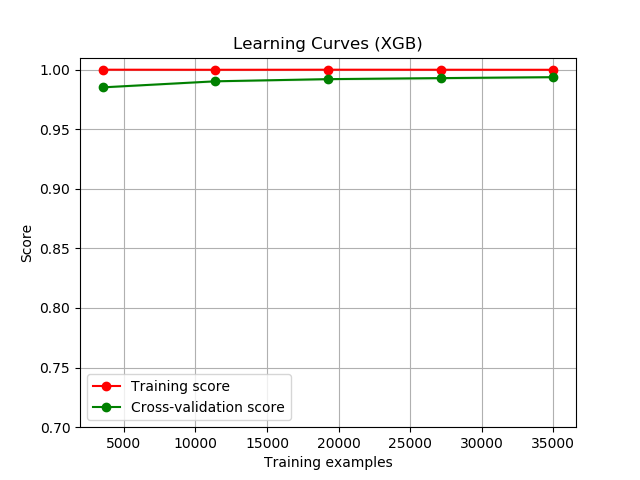

/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. U

In [387]:
title = "Learning Curves (XGB)"
cv_XGB = cross_validation.ShuffleSplit(data.shape[0], n_iter=2, test_size=0.2, random_state=0)
plt_XGB = plot_learning_curve(model_XGB, title, data, labels, ylim=(0.7, 1.01), cv=cv_XGB, n_jobs=2)
plt_XGB.show()

## Krajnji model

In [291]:
# we use the RandomizedSearchCV to find the best parameters for our XGB model
rand_XGB = RandomizedSearchCV(model_XGB, param_dist_XGB, cv=10, scoring='accuracy', n_iter=20, random_state=5, return_train_score=False)
rand_XGB.fit(data_new, labels)
pd.DataFrame(rand_XGB.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. U

/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. U

/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. U

/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. U

/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. U

/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. U

/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. U

,mean_test_score,std_test_score,params
0,0.726818,0.178333,"{'max_depth': 16, 'learning_rate': 3.0, 'base_..."
1,0.771492,0.136141,"{'max_depth': 55, 'learning_rate': 2.3, 'base_..."
2,0.991321,0.003401,"{'max_depth': 80, 'learning_rate': 1.1, 'base_..."
3,0.990659,0.004052,"{'max_depth': 18, 'learning_rate': 1.0, 'base_..."
4,0.991595,0.003167,"{'max_depth': 47, 'learning_rate': 0.1, 'base_..."
5,0.989677,0.004035,"{'max_depth': 87, 'learning_rate': 1.3, 'base_..."
6,0.647337,0.140292,"{'max_depth': 21, 'learning_rate': 2.6, 'base_..."
7,0.982825,0.007721,"{'max_depth': 14, 'learning_rate': 1.4, 'base_..."
8,0.991047,0.003408,"{'max_depth': 33, 'learning_rate': 1.1, 'base_..."
9,0.991504,0.002891,"{'max_depth': 41, 'learning_rate': 0.8, 'base_..."


<IPython.core.display.Javascript object>


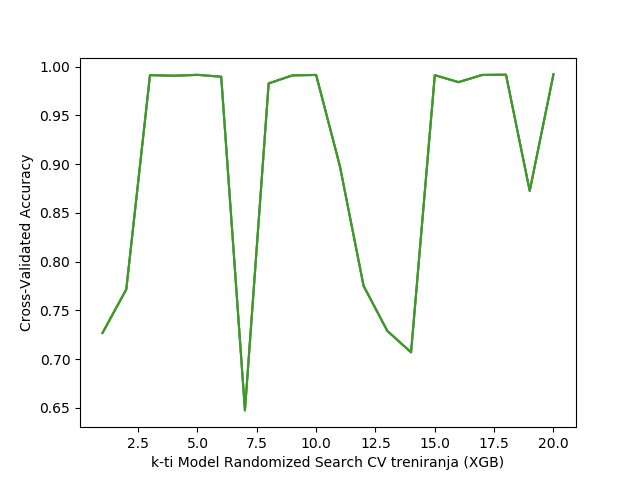

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


In [361]:
# plot of randomized search results
rand_XGB_mean_scores = rand_XGB.cv_results_['mean_test_score']
plt.plot(list(range(1, 21)), rand_XGB_mean_scores)
plt.xlabel('k-ti Model Randomized Search CV za XGB (30 znacajka)')
plt.ylabel('Cross-Validated Accuracy')

In [295]:
# examine the best model
print(rand_XGB.best_score_)
print(rand_XGB.best_params_)

0.9920518911017724
{'max_depth': 64, 'learning_rate': 0.3, 'base_score': 0.9}


In [388]:
final_model = XGBClassifier(max_depth = 64,
                            learning_rate = 0.3,
                            base_score = 0.9)

In [389]:
final_model.fit(data_new[m_train], labels[m_train])

XGBClassifier(base_score=0.9, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=64, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [390]:
y = final_model.predict(data_new[m_val])
print("Accuracy score", sklearn.metrics.accuracy_score(labels[m_val], y))

Accuracy score 0.990864451296106


/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [394]:
# exporting results of final model's validation files label prediction in datafile 'rjesenje.tsv' 
shas_final = shas[m_val]
labels_final = labels[m_val]
results_final = y
results_final
with open("rjesenje.tsv", "w") as record_file:
    record_file.write("sha\toznake\tpredviđanja")
    for i in range(0, len(shas_final)):
        record_file.write(str(shas_final[i])+"\t   "+str(labels_final[i])+ "\t\t  "+ str(results_final[i])+"\n")

<IPython.core.display.Javascript object>


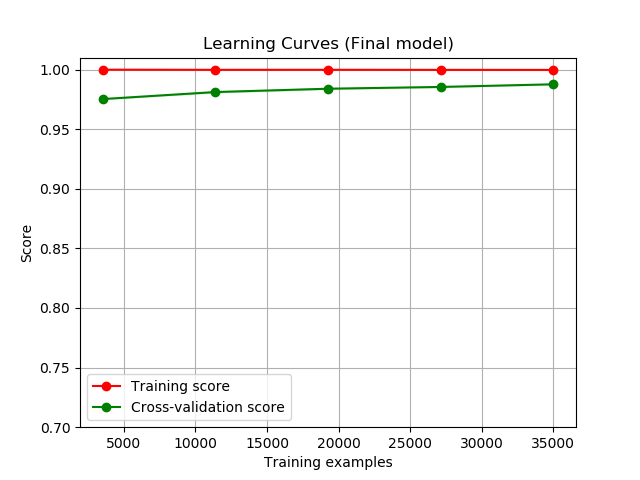

/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. U

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


In [357]:
title = "Learning Curves (Final model)"
cv_final = cross_validation.ShuffleSplit(data_new.shape[0], n_iter=2, test_size=0.2, random_state=0)
plt_final = plot_learning_curve(m_XGB, title, data_new, labels, ylim=(0.7, 1.01), cv=cv_final, n_jobs=2)
plt_final.show()
tikz_save('Final_model.tikz',
       figureheight = '\\figureheight',
       figurewidth = '\\figurewidth')